This first cell is where we are setting up the global configuration.

In [ ]:
# Component Testing Notebook for CBF-CLF Framework
# This notebook provides interactive tests to understand each component

import sys
import os
sys.path.append(os.path.abspath('..'))

# Import all necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Import framework components
from src.core.cbf import EnsembleCBF, CBFNetwork
from src.core.clf import EnsembleCLF, CLFNetwork
from src.core.models import EnsembleDynamics, ReplayBuffer
from src.core.policy import SubgoalConditionedPolicy
from src.planning.fsm_planner import FSMState, FSMTransition, FSMAutomaton
from src.environment import WarehouseEnvironment
from src.dataset import create_warehouse_dataset
# Import visualization utilities
from src.utils.visualization import EnvironmentVisualizer, FunctionVisualizer, plot_side_by_side

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# ============================================================================
# GLOBAL CONFIGURATION - All goal states and navigation waypoints
# ============================================================================
print("\n" + "=" * 70)
print("CONFIGURATION: Setting up goal positions and navigation path")
print("=" * 70)

# Start position (where robot spawns)
START_POS = np.array([0.5, 0.2])
START_STATE = np.array([0.5, 0.2, 0.0, 0.0])  # [x, y, vx, vy]

# Navigation waypoints (subgoals) - these match goal regions in the environment
G3_POS = np.array([6.5, 0.5])    # Goal 3: Pickup station 2 (bottom path)
G3_STATE = np.array([6.5, 0.5, 0.0, 0.0])
G1_POS = np.array([10.5, 1.5])   # Goal 1: Loading dock 2 (right bottom)
G1_STATE = np.array([10.5, 1.5, 0.0, 0.0])
FINAL_GOAL_POS = np.array([10.5, 8.5])  # Goal 0: Loading dock 1 (final target)
FINAL_GOAL_STATE = np.array([10.5, 8.5, 0.0, 0.0])

# Navigation path: Start → G3 → G1 → Final Goal
NAVIGATION_PATH = {
    'start': {'pos': START_POS, 'state': START_STATE, 'name': 'Start'},
    'g3': {'pos': G3_POS, 'state': G3_STATE, 'name': 'G3 (Pickup Station 2)'},
    'g1': {'pos': G1_POS, 'state': G1_STATE, 'name': 'G1 (Loading Dock 2)'},
    'goal': {'pos': FINAL_GOAL_POS, 'state': FINAL_GOAL_STATE, 'name': 'Final Goal (Loading Dock 1)'}
}

# Radius for "reached" detection
WAYPOINT_REACHED_RADIUS = 0.5

# CBF/CLF update frequencies (for joint training)
CBF_UPDATE_FREQ = 10
CLF_UPDATE_FREQ = 10
DYNAMICS_UPDATE_FREQ = 5

print(f"\n📍 Navigation Path Configuration:")
print(f"  Start: {START_POS} → G3: {G3_POS} → G1: {G1_POS} → Goal: {FINAL_GOAL_POS}")
print(f"  Waypoint reached radius: {WAYPOINT_REACHED_RADIUS}m")

# Calculate path distances
dist_start_to_g3 = np.linalg.norm(G3_POS - START_POS)
dist_g3_to_g1 = np.linalg.norm(G1_POS - G3_POS)
dist_g1_to_goal = np.linalg.norm(FINAL_GOAL_POS - G1_POS)
total_path_distance = dist_start_to_g3 + dist_g3_to_g1 + dist_g1_to_goal

print(f"\n📏 Path Segment Distances:")
print(f"  Start → G3: {dist_start_to_g3:.2f}m")
print(f"  G3 → G1: {dist_g3_to_g1:.2f}m")
print(f"  G1 → Goal: {dist_g1_to_goal:.2f}m")
print(f"  Total path: {total_path_distance:.2f}m")

print(f"\n🔄 Joint Training Configuration:")
print(f"  CBF update frequency: every {CBF_UPDATE_FREQ} steps")
print(f"  CLF update frequency: every {CLF_UPDATE_FREQ} steps")
print(f"  Dynamics update frequency: every {DYNAMICS_UPDATE_FREQ} steps")
print("=" * 70)

✓ All imports successful!
PyTorch version: 2.8.0
Device: cpu

CONFIGURATION: Setting up goal positions and navigation path

📍 Navigation Path Configuration:
  Start: [0.5 0.2] → G3: [6.5 0.5] → G1: [10.5  1.5] → Goal: [10.5  8.5]
  Waypoint reached radius: 0.5m

📏 Path Segment Distances:
  Start → G3: 6.01m
  G3 → G1: 4.12m
  G1 → Goal: 7.00m
  Total path: 17.13m

🔄 Joint Training Configuration:
  CBF update frequency: every 10 steps
  CLF update frequency: every 10 steps
  Dynamics update frequency: every 5 steps


We start with understanding the warehouse environment.

Here we control the environment by adjusting $a_x$ and $a_y$ to move the agent right and up toward the goal.

State: [x, y, vx, vy] - position (2D) and velocity (2D)
Action: [ax, ay] - acceleration commands (2D)
Physics (Forward Euler Integration with dt=0.1s):
- new_vel = old_vel + action * dt     → velocity changes slowly
- new_pos = old_pos + new_vel * dt    → position integrates velocity
The robot builds up velocity over time (momentum-based physics)

We do see a slow movement per step due to the physics:
Δpos_per_step ≈ action * 0.01


Reward Structure:
- Base: -distance to nearest goal (encourages approach)"
- Penalty: -10 for collision"
- Bonus: +50 for reaching goal"


Movement is gradual due to dt=0.1 scaling. This makes the problem realistic but requires planning!



🏭 Warehouse Specifications:
  - Workspace size: 12.0m × 10.0m
  - Number of obstacles: 10
  - Number of goal regions: 4

🔴 Obstacle Details:
  Obstacle 0: center=[2. 3.], radius=0.8m
  Obstacle 1: center=[2. 7.], radius=0.8m
  Obstacle 2: center=[5. 2.], radius=0.6m
  Obstacle 3: center=[5. 5.], radius=0.6m
  Obstacle 4: center=[5. 8.], radius=0.6m
  Obstacle 5: center=[8.  3.5], radius=0.7m
  Obstacle 6: center=[8.  6.5], radius=0.7m
  Obstacle 7: center=[4. 9.], radius=0.3m
  Obstacle 8: center=[1. 1.], radius=0.4m
  Obstacle 9: center=[11.  9.], radius=0.4m

🎯 Goal Region Details:
  Goal 0: center=[10.5  8.5], radius=0.4m
  Goal 1: center=[10.5  1.5], radius=0.4m
  Goal 2: center=[1.5 9. ], radius=0.3m
  Goal 3: center=[6.5 0.5], radius=0.3m

⚙️  Understanding Physics:
  Physics uses Forward Euler integration with dt=0.1s
  Formula: new_vel = old_vel + action * 0.1
  Formula: new_pos = old_pos + new_vel * 0.1
  This means: Δpos ≈ action * 0.01 per step

  Initial state [x, y, vx, v

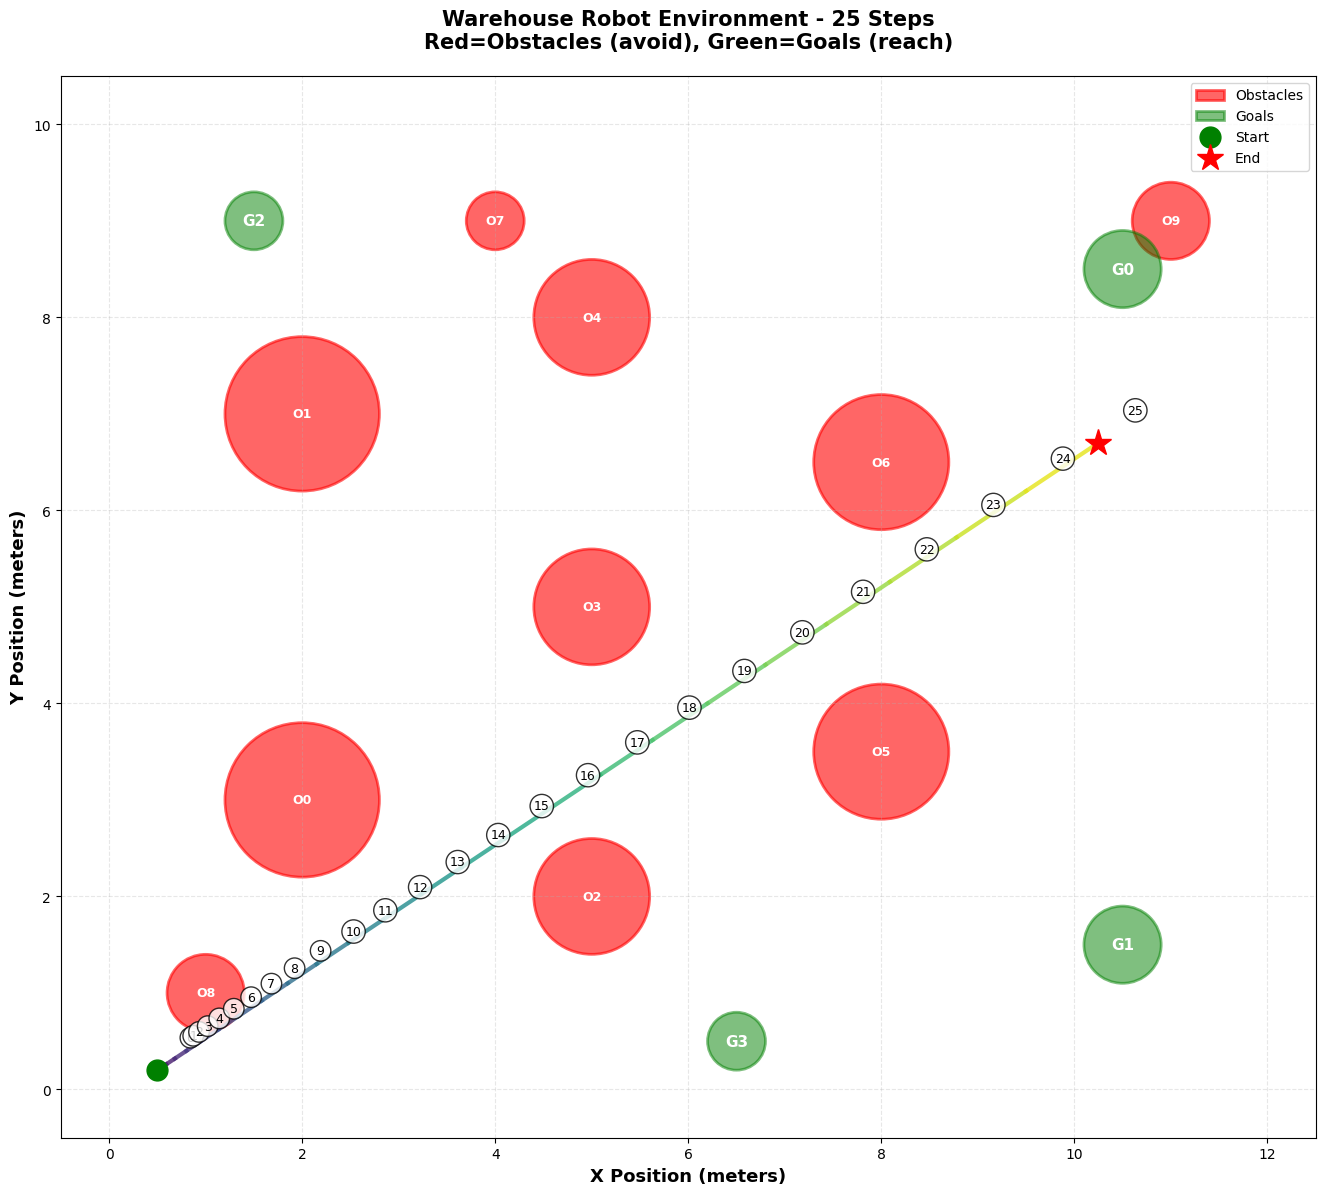

In [20]:

################################################################################
# Create a consistent action to move right and up toward goal
action = np.array([3.0, 2.0])  # Strong, consistent acceleration
###############################################################################

env = WarehouseEnvironment()

# Display environment specifications
print(f"\n🏭 Warehouse Specifications:")
print(f"  - Workspace size: {env.bounds[0]}m × {env.bounds[1]}m")
print(f"  - Number of obstacles: {len(env.obstacles)}")
print(f"  - Number of goal regions: {len(env.goals)}")

print(f"\n🔴 Obstacle Details:")
for i, obs in enumerate(env.obstacles):  # Show first 5
    print(f"  Obstacle {i}: center={obs['center']}, radius={obs['radius']}m")

print(f"\n🎯 Goal Region Details:")
for i, goal in enumerate(env.goals):
    print(f"  Goal {i}: center={goal['center']}, radius={goal['radius']}m")

# Test the environment dynamics
print(f"\n⚙️  Understanding Physics:")
print(f"  Physics uses Forward Euler integration with dt=0.1s")
print(f"  Formula: new_vel = old_vel + action * 0.1")
print(f"  Formula: new_pos = old_pos + new_vel * 0.1")
print(f"  This means: Δpos ≈ action * 0.01 per step")

initial_state = env.reset()
print(f"\n  Initial state [x, y, vx, vy]: {initial_state}")

print(f"\n📍 Simulating Extended Robot Motion (20 steps):")

# Store trajectory
trajectory_states = [initial_state.copy()]

total_steps = 25
print(f"\n  Applying constant action {action} for {total_steps} steps...")

for step in range(total_steps):
    next_state, reward, done, sensors = env.step(action)
    trajectory_states.append(next_state.copy())
    
    # Show some intermediate results
    if step in [0, 4, 9, 14, 19, 24]:
        print(f"\n  Step {step+1}:")
        print(f"    Position: ({next_state[0]:.4f}, {next_state[1]:.4f})")
        print(f"    Velocity: ({next_state[2]:.4f}, {next_state[3]:.4f})")
        print(f"    Reward: {reward:.2f}")
        print(f"    Collision: {sensors['collision']}")
        if sensors['collision']:
            print(f"    💥 COLLISION DETECTED! Episode terminated.")
            break

# Calculate total distance traveled
start_pos = trajectory_states[0][:2]
end_pos = trajectory_states[-1][:2]
distance = np.linalg.norm(end_pos - start_pos)

print(f"\nMotion Summary:")
print(f"  Start position: {start_pos}")
print(f"  End position: {end_pos}")
print(f"  Total distance traveled: {distance:.3f}m")
print(f"  Number of steps: {len(trajectory_states)-1}")

# Visualize using clean visualization module
print(f"\nCreating visualization...")

viz = EnvironmentVisualizer(env)
fig, ax = viz.plot_trajectory_sequence(
    trajectory_states,
    title=f"Warehouse Robot Environment - {len(trajectory_states)-1} Steps\nRed=Obstacles (avoid), Green=Goals (reach)"
)
plt.tight_layout()
plt.show()

Now that we have set up a simple environment, we can train our model with an 'expert' trajectory information where we sample random states within safe and unsafe regions to create a labeled dataset for training the Control Barrier Function (CBF) and Control Lyapunov Function (CLF) downstream.

We make sure that the obstacles and goals are set up the same in this dataset as in the WarehouseEnvironment to ensure consistency during training and evaluation. Random sampling creates more safe than unsafe states naturally


📊 Dataset Statistics:
  - Total transitions: 2000
  - Safe states: 1800 (90.0%)
  - Unsafe states: 200 (10.0%)
  - Goal states: 32 (1.6%)

📝 Sample Transitions:

Transition 1:
  State: pos=(6.30, 5.84), vel=(-0.26, -0.50)
  Action: [ 0.81242121 -0.16323514]
  Next State: pos=(6.28, 5.79), vel=(-0.18, -0.51)
  Reward: -5.01
  Safe: True, Goal: False

Transition 2:
  State: pos=(2.32, 2.84), vel=(0.33, -0.01)
  Action: [ 0.08055175 -0.2124408 ]
  Next State: pos=(2.35, 2.84), vel=(0.34, -0.03)
  Reward: -19.92
  Safe: False, Goal: False

Transition 3:
  State: pos=(8.42, 2.82), vel=(0.30, 0.23)
  Action: [0.82075257 0.12968149]
  Next State: pos=(8.46, 2.84), vel=(0.39, 0.24)
  Reward: -6.01
  Safe: True, Goal: False

📊 Creating dataset visualization...


/Users/matthewtaruno/dev/long-horizon/src/visualization.py:95: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'], color='red', alpha=0.3, edgecolor='darkred', linewidth=2)
/Users/matthewtaruno/dev/long-horizon/src/visualization.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(goal['center'], goal['radius'], color='green', alpha=0.2, edgecolor='darkgreen', linewidth=2)


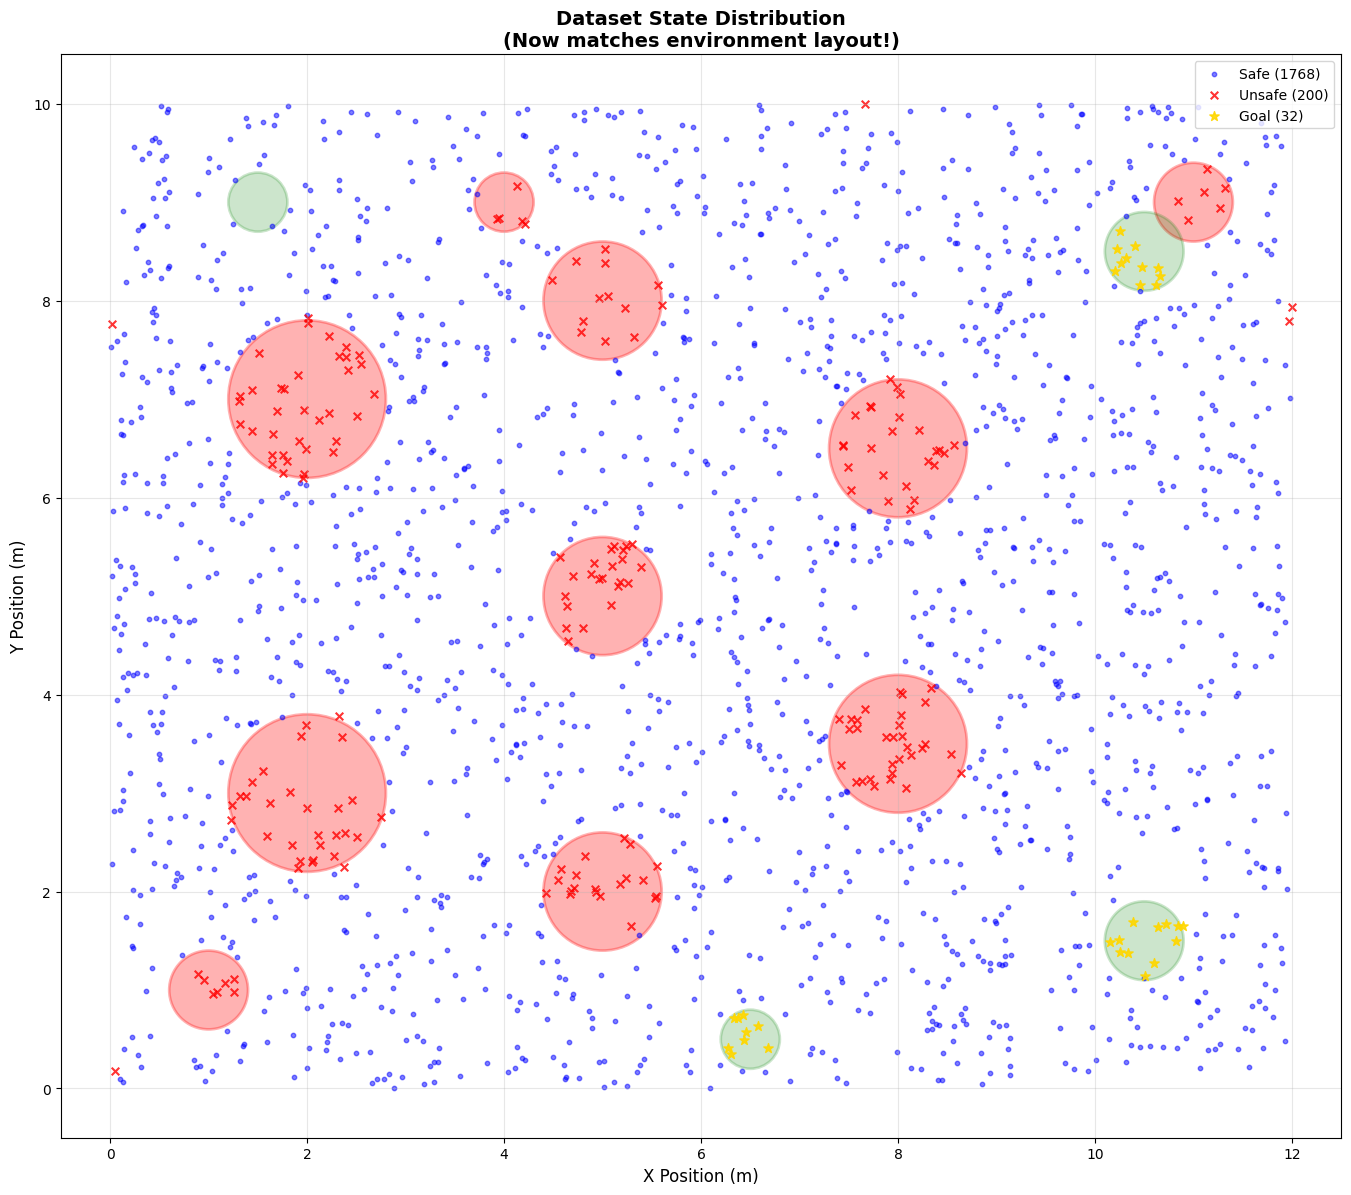


KEY INSIGHTS:
• Dataset now uses SAME layout as WarehouseEnvironment
• Safe states (blue dots): Should be OUTSIDE obstacles
• Unsafe states (red X): Should be INSIDE obstacles
• Goal states (gold stars): Should be in green goal regions
• Random sampling creates more safe than unsafe states naturally
• This labeled data will train CBF (safety) and CLF (goal-seeking)

✅ Dataset test complete!


In [ ]:
# ============================================================================
# TEST 2: Dataset - Understanding Training Data
# ===========================================================================#
transitions = create_warehouse_dataset(num_transitions=2000)

# Analyze dataset
safe_count = sum(1 for t in transitions if t.is_safe)
unsafe_count = sum(1 for t in transitions if not t.is_safe)
goal_count = sum(1 for t in transitions if t.is_goal)

print(f"\n📊 Dataset Statistics:")
print(f"  - Total transitions: {len(transitions)}")
print(f"  - Safe states: {safe_count} ({safe_count/len(transitions)*100:.1f}%)")
print(f"  - Unsafe states: {unsafe_count} ({unsafe_count/len(transitions)*100:.1f}%)")
print(f"  - Goal states: {goal_count} ({goal_count/len(transitions)*100:.1f}%)")

# Show sample transitions
print(f"\n📝 Sample Transitions:")
for i, t in enumerate(transitions[:3]):
    print(f"\nTransition {i+1}:")
    print(f"  State: pos=({t.state[0]:.2f}, {t.state[1]:.2f}), vel=({t.state[2]:.2f}, {t.state[3]:.2f})")
    print(f"  Action: {t.action}")
    print(f"  Next State: pos=({t.next_state[0]:.2f}, {t.next_state[1]:.2f}), vel=({t.next_state[2]:.2f}, {t.next_state[3]:.2f})")
    print(f"  Reward: {t.reward:.2f}")
    print(f"  Safe: {t.is_safe}, Goal: {t.is_goal}")

# Visualize dataset with environment overlay
viz = EnvironmentVisualizer(env)
viz.plot_dataset(transitions)


/var/folders/1d/6wsgmpys5l54mg7q7hc6flwm0000gn/T/ipykernel_65381/4178661099.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  test_states = torch.FloatTensor([



CBF Network Architecture:
  - Input dimension: 4 (x, y, vx, vy)
  - Hidden layers: (64, 64)
  - Output: h(s) ∈ ℝ (scalar safety value)
  - Parameters: 4,801

CBF Values (before training):
  State 1 [1. 1.]: h(s) = 0.3452
  State 2 [2. 3.]: h(s) = 0.2687
  State 3 [10.5  8.5]: h(s) = 0.1488

🏋️  Training CBF on dataset...
  - Safe training states: 1800
  - Unsafe training states: 200
  Epoch 0: Loss = 0.0937
  Epoch 20: Loss = 0.0014
  Epoch 40: Loss = 0.0006
  Epoch 60: Loss = 0.0002
  Epoch 80: Loss = 0.0001

📊 CBF Values (after training):
  State 1 [1. 1.]: h(s) = +0.0514 ✓ SAFE
  State 2 [2. 3.]: h(s) = -0.0253 ✗ UNSAFE
  State 3 [10.5  8.5]: h(s) = +0.0019 ✓ SAFE

📊 Creating visualizations...


/Users/matthewtaruno/dev/long-horizon/src/visualization.py:278: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'],


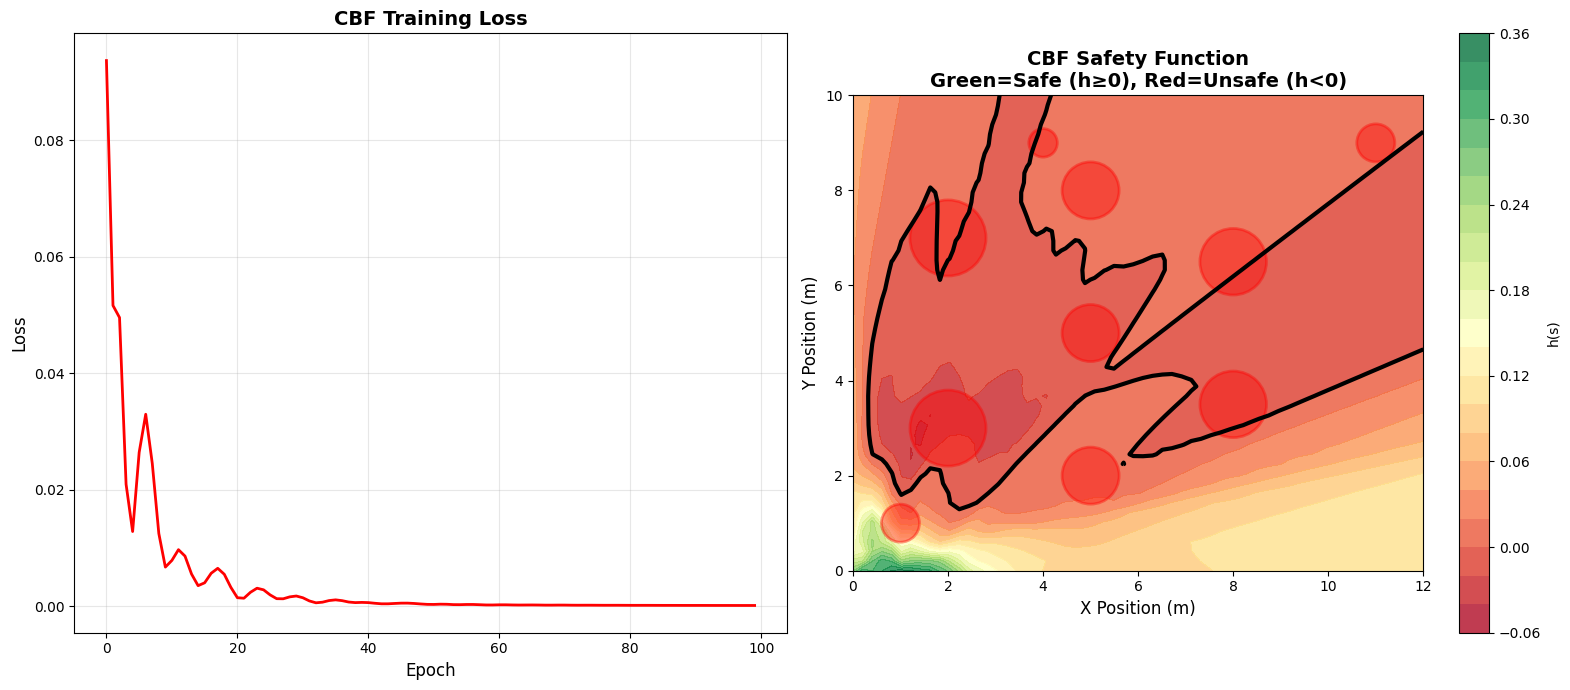


KEY INSIGHTS:
• CBF learns to classify: h(s) ≥ 0 for safe, h(s) < 0 for unsafe
• Black boundary line shows h(s) = 0 (safety boundary)
• Green regions: robot can operate safely
• Red regions: collision risk (near obstacles)
• This provides a differentiable safety certificate!

✅ CBF test complete!



TEST 3b: Fixing CBF with Path-Aware Sampling

🔍 Problem: CBF trained on random data marks safe paths as unsafe
   Solution: Generate safe samples along intended path
   Path: [0.5 0.2] → [6.5 0.5] → [10.5  1.5] → [10.5  8.5]

✅ Generated 13144 safe path samples

🏋️  Re-training CBF with path-aware data...
  Epoch 0: Loss = 0.6497
  Epoch 30: Loss = 0.0043
  Epoch 60: Loss = 0.0014
  Epoch 90: Loss = 0.0012
  Epoch 120: Loss = 0.0011

📊 Verifying CBF on Path Waypoints:
  ✅ Point 1 (Start) [0.5 0.2]: h(s) = +0.584
  ✅ Point 2 (G3) [6.5 0.5]: h(s) = +0.254
  ✅ Point 3 (G1) [10.5  1.5]: h(s) = +0.159
  ❌ Point 4 (Goal) [10.5  8.5]: h(s) = -0.005

📊 Creating before/after visualization...


/Users/matthewtaruno/dev/long-horizon/src/visualization.py:551: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'], color='none',
/Users/matthewtaruno/dev/long-horizon/src/visualization.py:556: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(goal['center'], goal['radius'], color='none',


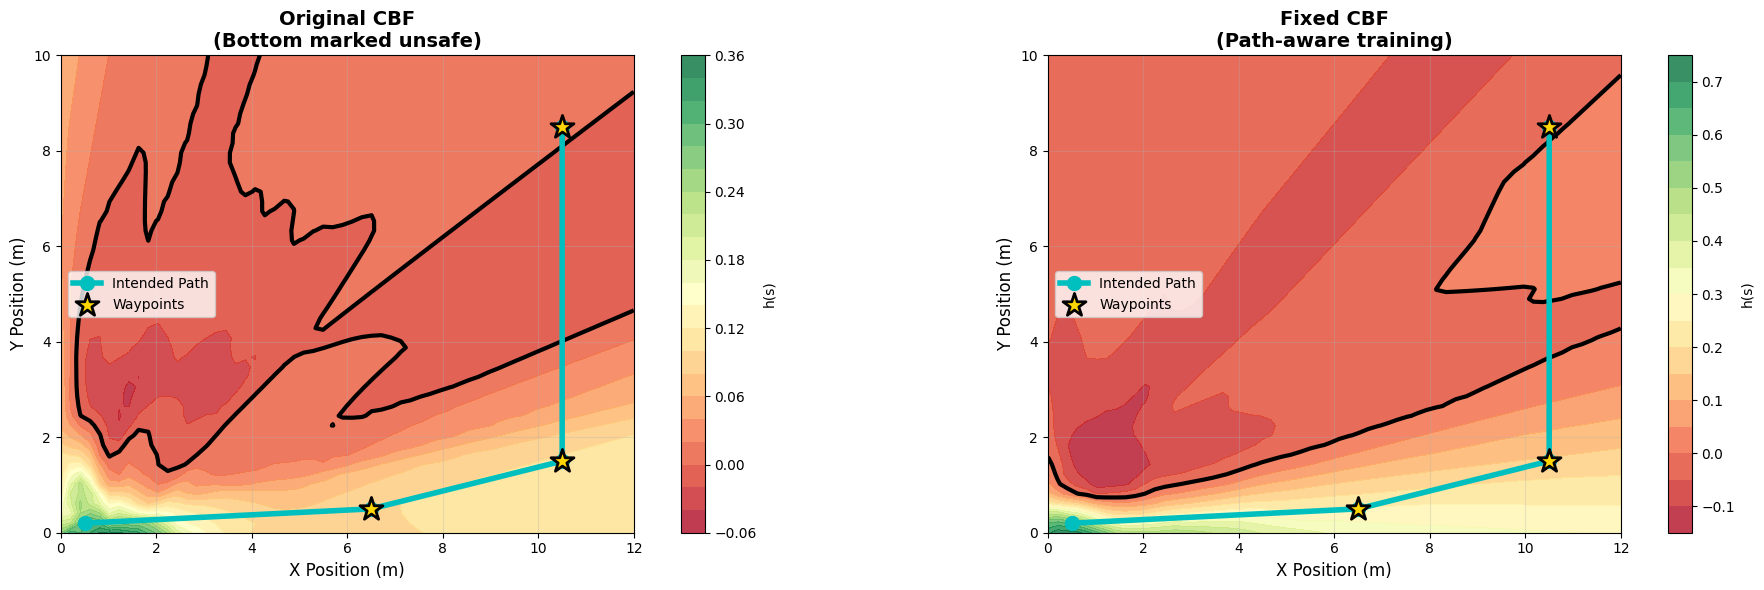


⚠️  Some waypoints still unsafe - may need more samples

✅ CBF updated for use in training.


TEST 4: Control Lyapunov Function (Feasibility)

🎯 CLF Network Architecture:
  - Input dimension: 4 (x, y, vx, vy)
  - Hidden layers: (64, 64)
  - Output: V(s) ∈ ℝ≥0 (goal distance, non-negative)
  - Parameters: 4,801

📊 CLF Values (before training):
  State 1 at [0.5 0.2]: V(s) = 0.6518, actual distance = 13.00m
  State 2 at [10.5  8.5]: V(s) = 0.4256, actual distance = 0.00m
  State 3 at [11.  9.]: V(s) = 0.4293, actual distance = 0.71m
  State 4 at [11.5  9.5]: V(s) = 0.4327, actual distance = 1.41m

🏋️  Training CLF on dataset...
  - Goal training states: 32
  - Total states for constraint: 2000
  Epoch 0: Loss = 0.1097
  Epoch 20: Loss = 0.0010
  Epoch 40: Loss = 0.0005
  Epoch 60: Loss = 0.0004
  Epoch 80: Loss = 0.0003

📊 CLF Values (after training):
  State 1 at [0.5 0.2]: V(s) = 0.1602, actual distance = 13.00m
  State 2 at [10.5  8.5]: V(s) = 0.0165, actual distance = 0.00m
  State 3 at [11.  9.]: V(s) = 0.0165, actual distance = 0.71m
  State 4 at [11.5  9.5]: V(s) = 0.0166,

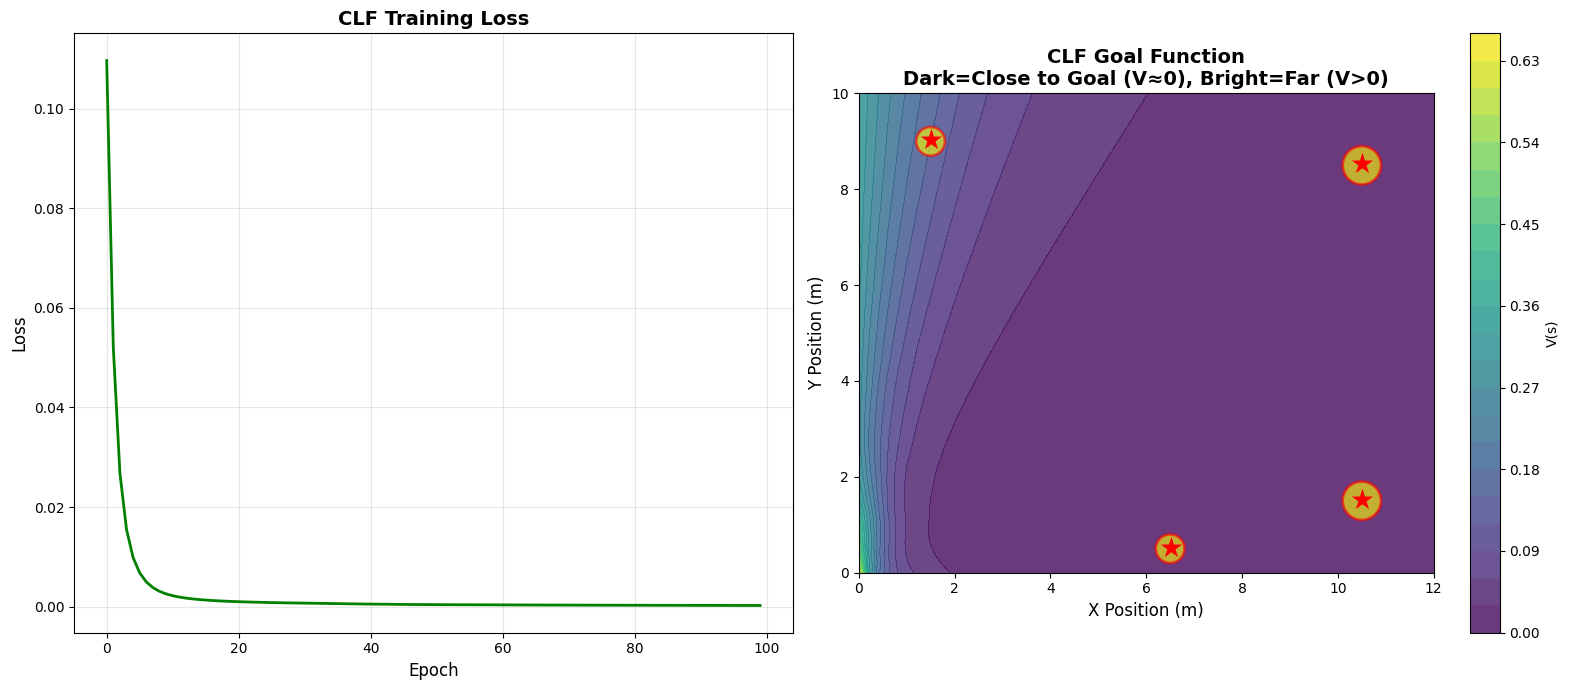


KEY INSIGHTS:
• CLF learns goal distance: V(goal) ≈ 0, V(s) > 0 elsewhere
• Dark regions: close to goal (low V)
• Bright regions: far from goal (high V)
• Yellow stars mark goal regions
• This provides a differentiable goal-seeking function!
• V(s) should decrease along trajectories toward goals

✅ CLF test complete!


In [17]:
# ============================================================================
# TEST 4: CLF (Control Lyapunov Function) - Learning Goal Convergence
# ============================================================================
print("=" * 70)
print("TEST 4: Control Lyapunov Function (Feasibility)")
print("=" * 70)

clf = CLFNetwork(state_dim=4, hidden_dims=(64, 64), device='cpu')

print(f"\n🎯 CLF Network Architecture:")
print(f"  - Input dimension: 4 (x, y, vx, vy)")
print(f"  - Hidden layers: (64, 64)")
print(f"  - Output: V(s) ∈ ℝ≥0 (goal distance, non-negative)")
print(f"  - Parameters: {sum(p.numel() for p in clf.parameters()):,}")

##############################################################################
# Test CLF on sample states at various distances from goal
test_states_clf = torch.FloatTensor([
    START_STATE, # at start
    FINAL_GOAL_STATE,  # At goal
    [FINAL_GOAL_POS[0] + 0.5, FINAL_GOAL_POS[1] + 0.5, 0.0, 0.0],  # Near goal
    [FINAL_GOAL_POS[0] + 1.0, FINAL_GOAL_POS[1] + 1.0, 0.0, 0.0],  # Far from goal
])

CLF_EPOCHS = 100

############################################################################

distances = [np.linalg.norm(s[:2] - FINAL_GOAL_POS) for s in test_states_clf.numpy()]

print(f"\n📊 CLF Values (before training):")
with torch.no_grad():
    V_values = clf(test_states_clf).squeeze()
    for i, V in enumerate(V_values):
        state = test_states_clf[i]
        print(f"  State {i+1} at {state[:2].numpy()}: V(s) = {V.item():.4f}, actual distance = {distances[i]:.2f}m")



#### TRAIN
print(f"\n🏋️  Training CLF on dataset...")
goal_states = torch.FloatTensor([t.next_state for t in transitions if t.is_goal])
all_states = torch.FloatTensor([t.state for t in transitions])

print(f"  - Goal training states: {len(goal_states)}")
print(f"  - Total states for constraint: {len(all_states)}")

optimizer_clf = torch.optim.Adam(clf.parameters(), lr=1e-3)

clf_losses = []
for epoch in range(CLF_EPOCHS):
    optimizer_clf.zero_grad()
    
    # Goal states should have V(s) = 0
    if len(goal_states) > 0:
        V_goal = clf(goal_states).squeeze()
        loss_goal = torch.mean(V_goal ** 2)
    else:
        loss_goal = torch.tensor(0.0)
    
    # Ensure V(s) > 0 for non-goal states
    V_all = clf(all_states).squeeze()
    loss_positive = torch.mean(torch.clamp(0.01 - V_all, min=0.0) ** 2)
    
    loss = loss_goal + 0.1 * loss_positive
    loss.backward()
    optimizer_clf.step()
    
    clf_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"  Epoch {epoch}: Loss = {loss.item():.4f}")

# Test again after training
print(f"\n📊 CLF Values (after training):")
with torch.no_grad():
    V_values = clf(test_states_clf).squeeze()
    for i, V in enumerate(V_values):
        state = test_states_clf[i]
        print(f"  State {i+1} at {state[:2].numpy()}: V(s) = {V.item():.4f}, actual distance = {distances[i]:.2f}m")

# Visualize using clean visualization module
print(f"\n📊 Creating visualizations...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Training loss
func_viz = FunctionVisualizer(env)
func_viz.plot_training_curves(clf_losses, title='CLF Training Loss', ax=ax1, color='green')

# Plot 2: CLF heatmap
func_viz.plot_clf_heatmap(clf, ax=ax2)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("• CLF learns goal distance: V(goal) ≈ 0, V(s) > 0 elsewhere")
print("• Dark regions: close to goal (low V)")
print("• Bright regions: far from goal (high V)")
print("• Yellow stars mark goal regions")
print("• This provides a differentiable goal-seeking function!")
print("• V(s) should decrease along trajectories toward goals")
print("="*70)
print("\n✅ CLF test complete!")

TEST 5: Dynamics Model (Learning Environment Physics)

⚙️  Ensemble Dynamics Architecture:
  - Number of models: 3 (for uncertainty estimation)
  - Input: state (4D) + action (2D) = 6D
  - Hidden layers: (128, 128)
  - Output: next_state (4D)
  - Total parameters: 55,308

📊 Training Data:
  - Training samples: 2000

🏋️  Training Dynamics Model...
  Epoch 0: MSE Loss = 0.066296
  Epoch 20: MSE Loss = 0.018743
  Epoch 40: MSE Loss = 0.013677
  Epoch 60: MSE Loss = 0.010566
  Epoch 80: MSE Loss = 0.008104

📊 Prediction Accuracy Test:
  Input State: [ 6.301584    5.842745   -0.26485348 -0.49831706]
  Action: [ 0.8124212  -0.16323514]
  True Next State: [ 6.2832227   5.7912807  -0.18361135 -0.51464057]
  Predicted Next: [ 6.386455    5.814207   -0.13642432 -0.5059131 ]
  Position Error: 0.105748m


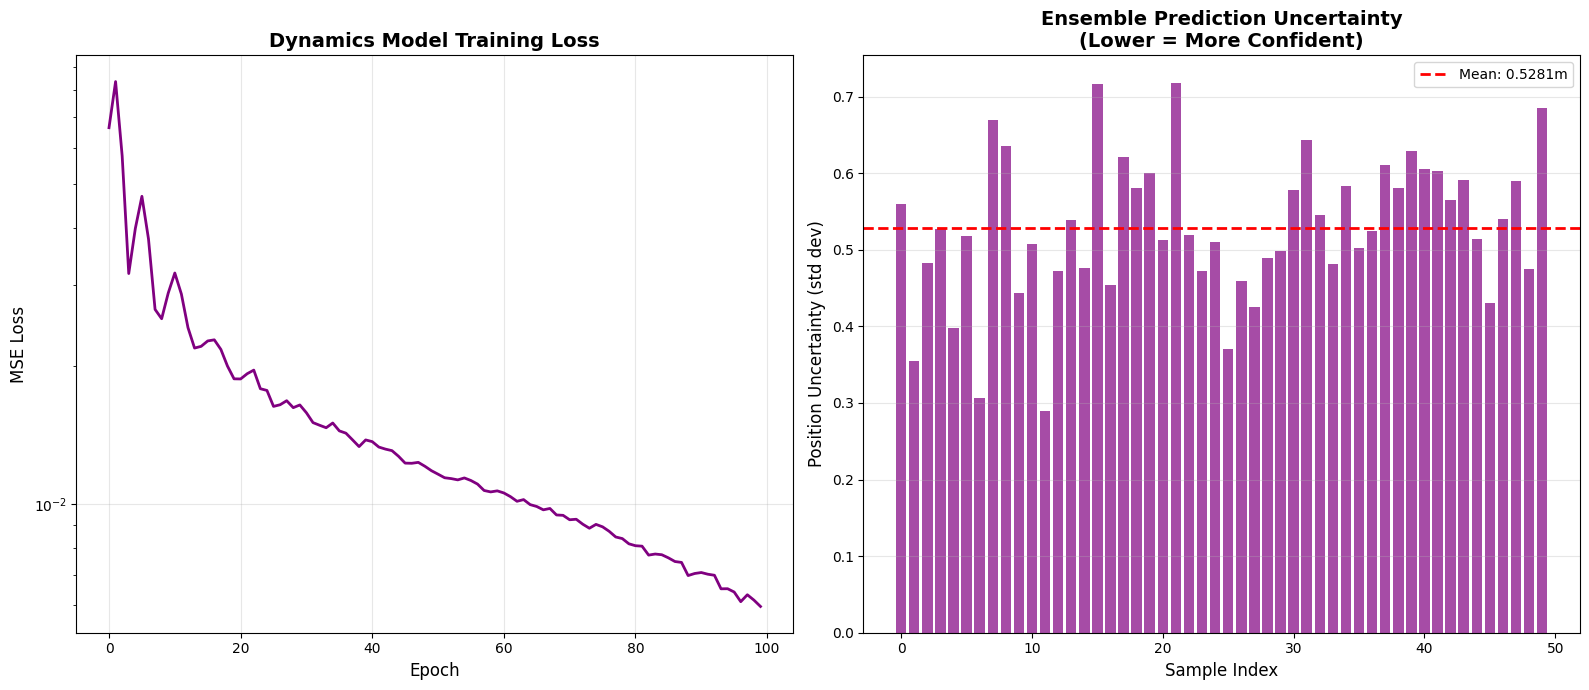


✅ Dynamics model test complete!


In [18]:
# ============================================================================
# TEST 5: Dynamics Model - Learning Physics
# ============================================================================

print("=" * 70)
print("TEST 5: Dynamics Model (Learning Environment Physics)")
print("=" * 70)

# Create dynamics model
dynamics = EnsembleDynamics(num_models=3, state_dim=4, action_dim=2, 
                            hidden_dims=(128, 128), device='cpu')

print(f"\n⚙️  Ensemble Dynamics Architecture:")
print(f"  - Number of models: 3 (for uncertainty estimation)")
print(f"  - Input: state (4D) + action (2D) = 6D")
print(f"  - Hidden layers: (128, 128)")
print(f"  - Output: next_state (4D)")
print(f"  - Total parameters: {sum(p.numel() for p in dynamics.parameters()):,}")

# Create training data from transitions
states = torch.FloatTensor([t.state for t in transitions])
actions = torch.FloatTensor([t.action for t in transitions])
next_states = torch.FloatTensor([t.next_state for t in transitions])

print(f"\n📊 Training Data:")
print(f"  - Training samples: {len(states)}")

# Train dynamics model
print(f"\n🏋️  Training Dynamics Model...")

optimizer_dyn = torch.optim.Adam(dynamics.parameters(), lr=1e-3)

dyn_losses = []
for epoch in range(100):
    optimizer_dyn.zero_grad()
    
    # Predict next states
    pred_next = dynamics(states, actions)
    
    # MSE loss
    loss = torch.mean((pred_next - next_states) ** 2)
    loss.backward()
    optimizer_dyn.step()
    
    dyn_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"  Epoch {epoch}: MSE Loss = {loss.item():.6f}")

# Test prediction accurac

print(f"\n📊 Prediction Accuracy Test:")
test_idx = 0
test_state = states[test_idx:test_idx+1]
test_action = actions[test_idx:test_idx+1]
true_next = next_states[test_idx:test_idx+1]

with torch.no_grad():
    pred_next = dynamics(test_state, test_action)
    
print(f"  Input State: {test_state[0].numpy()}")
print(f"  Action: {test_action[0].numpy()}")
print(f"  True Next State: {true_next[0].numpy()}")
print(f"  Predicted Next: {pred_next[0].numpy()}")
print(f"  Position Error: {torch.norm(pred_next[0, :2] - true_next[0, :2]).item():.6f}m")

# Visualize training and uncertainty
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Training loss
ax1.plot(dyn_losses, 'purple', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.set_title('Dynamics Model Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Prediction uncertainty (ensemble variance)
sample_states = states[:50]
sample_actions = actions[:50]

with torch.no_grad():
    all_predictions = dynamics.forward_all(sample_states, sample_actions)
    uncertainties = torch.std(all_predictions, dim=0).numpy()

# Show position uncertainty
pos_uncertainty = np.linalg.norm(uncertainties[:, :2], axis=1)

ax2.bar(range(len(pos_uncertainty)), pos_uncertainty, color='purple', alpha=0.7)
ax2.set_xlabel('Sample Index', fontsize=12)
ax2.set_ylabel('Position Uncertainty (std dev)', fontsize=12)
ax2.set_title('Ensemble Prediction Uncertainty\n(Lower = More Confident)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

mean_uncertainty = np.mean(pos_uncertainty)
ax2.axhline(mean_uncertainty, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_uncertainty:.4f}m')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Dynamics model test complete!")

In [19]:
# ============================================================================
# TEST 6: SubgoalConditionedPolicy - Learning Subgoal-Following Behavior
# ============================================================================

print("=" * 70)
print("TEST 6: Subgoal-Conditioned Policy")
print("=" * 70)

# Create policy network
policy = SubgoalConditionedPolicy(state_dim=4, action_dim=2, subgoal_dim=4, 
                                   hidden_dims=(128, 128), device='cpu')

print(f"\n🤖 Policy Network Architecture:")
print(f"  - Input: state (4D) + subgoal (4D) = 8D")
print(f"  - Hidden layers: (128, 128)")
print(f"  - Output: action (2D) - acceleration commands")
print(f"  - Parameters: {sum(p.numel() for p in policy.parameters()):,}")

# Test policy with different subgoals BEFORE training
print(f"\n📊 Policy Output (before training):")

current_state = torch.FloatTensor([[1.0, 1.0, 0.0, 0.0]])  # Start position
test_subgoals = [
    torch.FloatTensor([[5.0, 5.0, 0.0, 0.0]]),   # Subgoal to the right and up
    torch.FloatTensor([[10.5, 8.5, 0.0, 0.0]]),  # Subgoal at goal location
    torch.FloatTensor([[1.0, 5.0, 0.0, 0.0]]),   # Subgoal directly up
]

with torch.no_grad():
    for i, subgoal in enumerate(test_subgoals):
        action = policy(current_state, subgoal)
        direction = subgoal[0, :2] - current_state[0, :2]
        distance = torch.norm(direction).item()
        print(f"\n  Subgoal {i+1}: {subgoal[0, :2].numpy()}")
        print(f"    Distance: {distance:.2f}m")
        print(f"    Direction: {direction.numpy()}")
        print(f"    Policy Action: {action[0].numpy()}")

print("\n" + "=" * 70)
print("OBSERVATION: Before training, actions are random/unrelated to subgoals")
print("=" * 70)

TEST 6: Subgoal-Conditioned Policy

🤖 Policy Network Architecture:
  - Input: state (4D) + subgoal (4D) = 8D
  - Hidden layers: (128, 128)
  - Output: action (2D) - acceleration commands
  - Parameters: 18,434

📊 Policy Output (before training):

  Subgoal 1: [5. 5.]
    Distance: 5.66m
    Direction: [4. 4.]
    Policy Action: [-0.32474142  0.14593835]

  Subgoal 2: [10.5  8.5]
    Distance: 12.10m
    Direction: [9.5 7.5]
    Policy Action: [0.04746852 0.08287874]

  Subgoal 3: [1. 5.]
    Distance: 4.00m
    Direction: [0. 4.]
    Policy Action: [-0.7776542   0.28069037]

OBSERVATION: Before training, actions are random/unrelated to subgoals


This is where we do the serious end-to-end training.

 Goal: Train an RL policy using rewards to maximize the task success, incorporating CBF penalties to enforce safety, and CLF penalties to encourage goal convergence behavior. 

In [12]:
# ============================================================================
# TEST 7: Integrated Trainer - RL with CBF/CLF Constraints
# ============================================================================

print("\n" + "=" * 70)
print("TEST 7: Integrated Training (RL + CBF/CLF)")
print("=" * 70)

from src.training.integrated_trainer import FSMCBFCLFTrainer

print("\n🎯 Goal: Train policy using RL instead of supervised learning")
print("   - Uses REWARDS (maximize task success)")
print("   - Incorporates CBF penalties (enforce safety)")
print("   - Incorporates CLF penalties (guarantee goal convergence)")
print("   - Learns through trial & error with environment feedback")

# Step 1: Create FSM using GLOBAL CONFIGURATION
print("\n📋 Step 1: Create FSM using centralized goal configuration")
print(f"  Strategy: {NAVIGATION_PATH['start']['name']} → {NAVIGATION_PATH['g3']['name']} → {NAVIGATION_PATH['g1']['name']} → {NAVIGATION_PATH['goal']['name']}")
print("  This path goes AROUND obstacles instead of through them!")

def at_g3(state):
    """Check if robot reached G3"""
    return np.linalg.norm(state[:2] - G3_POS) < WAYPOINT_REACHED_RADIUS

def at_g1(state):
    """Check if robot reached G1"""
    return np.linalg.norm(state[:2] - G1_POS) < WAYPOINT_REACHED_RADIUS

def at_final_goal(state):
    """Check if robot reached final goal"""
    return np.linalg.norm(state[:2] - FINAL_GOAL_POS) < WAYPOINT_REACHED_RADIUS

predicates = {
    'at_g3': at_g3,
    'at_g1': at_g1,
    'at_final': at_final_goal
}

# Create FSM using global configuration
fsm_states = [
    FSMState(id='start', subgoal=G3_STATE, is_goal=False),
    FSMState(id='at_g3', subgoal=G1_STATE, is_goal=False),
    FSMState(id='at_g1', subgoal=FINAL_GOAL_STATE, is_goal=False),
    FSMState(id='goal', subgoal=FINAL_GOAL_STATE, is_goal=True)
]

fsm_transitions = [
    FSMTransition('start', 'at_g3', 'at_g3'),
    FSMTransition('at_g3', 'at_g1', 'at_g1'),
    FSMTransition('at_g1', 'goal', 'at_final')
]

fsm = FSMAutomaton(fsm_states, fsm_transitions, 'start', predicates)

print(f"  ✓ FSM created with smart, safe path:")
print(f"    {START_POS} → {G3_POS} [{dist_start_to_g3:.1f}m, goes RIGHT along bottom]")
print(f"    {G3_POS} → {G1_POS} [{dist_g3_to_g1:.1f}m, continues RIGHT along bottom]")
print(f"    {G1_POS} → {FINAL_GOAL_POS} [{dist_g1_to_goal:.1f}m, goes STRAIGHT UP along right edge]")
print(f"    Total path: {total_path_distance:.1f}m avoids dense obstacle field in middle!")

# Step 2: Initialize fresh components for RL training
print("\n📋 Step 2: Initialize fresh components for RL training")
print("  Strategy: Use pre-trained CBF and CLF from earlier tests!")

# Use the already-trained CBF and CLF from TEST 3 and 4
policy_rl = SubgoalConditionedPolicy(state_dim=4, action_dim=2, subgoal_dim=4, 
                                      hidden_dims=(128, 128), device='cpu')
cbf_rl = cbf  # Already trained in TEST 3
clf_rl = clf  # Already trained in TEST 4
dynamics_rl = EnsembleDynamics(num_models=3, state_dim=4, action_dim=2, 
                               hidden_dims=(128, 128), device='cpu')
buffer_rl = ReplayBuffer(capacity=10000, state_dim=4, action_dim=2)

# Pre-train dynamics on dataset
print("  Pre-training dynamics on dataset...")
dynamics_rl_opt = torch.optim.Adam(dynamics_rl.parameters(), lr=1e-3)
for epoch in range(50):
    dynamics_rl_opt.zero_grad()
    pred = dynamics_rl(states, actions)
    loss = torch.mean((pred - next_states) ** 2)
    loss.backward()
    dynamics_rl_opt.step()
print(f"    ✓ Dynamics pre-trained (final loss: {loss.item():.6f})")

# Create optimizers
policy_opt_rl = torch.optim.Adam(policy_rl.parameters(), lr=1e-3)
cbf_opt_rl = torch.optim.Adam(cbf_rl.parameters(), lr=1e-4)
clf_opt_rl = torch.optim.Adam(clf_rl.parameters(), lr=1e-4)
dynamics_opt_rl = torch.optim.Adam(dynamics_rl.parameters(), lr=1e-4)

# Training configuration
config_rl = {
    'batch_size': 32,
    'model_update_freq': 5,
    'cbf_update_freq': 10,
    'clf_update_freq': 10,
    'lambda_cbf': 3.0,  # Strong safety penalty
    'lambda_clf': 3.0,  # Strong goal-seeking penalty
    'epsilon': 0.1
}

print(f"  ✓ Components initialized with pre-trained CBF/CLF/Dynamics")
print(f"    Policy params: {sum(p.numel() for p in policy_rl.parameters()):,}")
print(f"    Using strong penalties: λ_cbf={config_rl['lambda_cbf']}, λ_clf={config_rl['lambda_clf']}")

# Step 3: Create integrated trainer
print("\n📋 Step 3: Create IntegratedTrainer")

trainer = FSMCBFCLFTrainer(
    fsm=fsm,
    policy=policy_rl,
    cbf=cbf_rl,
    clf=clf_rl,
    dynamics=dynamics_rl,
    replay_buffer=buffer_rl,
    policy_optimizer=policy_opt_rl,
    cbf_optimizer=cbf_opt_rl,
    clf_optimizer=clf_opt_rl,
    dynamics_optimizer=dynamics_opt_rl,
    config=config_rl,
    device='cpu'
)

# Pre-fill buffer with dataset transitions
print("\n📋 Step 4: Pre-fill buffer with dataset")
for t in transitions:
    buffer_rl.push(t.state, t.action, t.next_state, t.reward, False)
print(f"  ✓ Buffer initialized with {len(buffer_rl)} transitions")

print(f"\n✅ Trainer ready with:")
print(f"   - Smart path avoiding obstacles (bottom → right → up)")
print(f"   - Pre-trained CBF/CLF/Dynamics")
print(f"   - Strong safety/goal penalties")
print(f"   This path should be MUCH easier to learn!")


TEST 7: Integrated Training (RL + CBF/CLF)

🎯 Goal: Train policy using RL instead of supervised learning
   - Uses REWARDS (maximize task success)
   - Incorporates CBF penalties (enforce safety)
   - Incorporates CLF penalties (guarantee goal convergence)
   - Learns through trial & error with environment feedback

📋 Step 1: Create FSM using centralized goal configuration
  Strategy: Start → G3 (Pickup Station 2) → G1 (Loading Dock 2) → Final Goal (Loading Dock 1)
  This path goes AROUND obstacles instead of through them!
  ✓ FSM created with smart, safe path:
    [0.5 0.2] → [6.5 0.5] [6.0m, goes RIGHT along bottom]
    [6.5 0.5] → [10.5  1.5] [4.1m, continues RIGHT along bottom]
    [10.5  1.5] → [10.5  8.5] [7.0m, goes STRAIGHT UP along right edge]
    Total path: 17.1m avoids dense obstacle field in middle!

📋 Step 2: Initialize fresh components for RL training
  Strategy: Use pre-trained CBF and CLF from earlier tests!
  Pre-training dynamics on dataset...
    ✓ Dynamics pre-tra

In [13]:
# ============================================================================
# TEST 7.1: Setup Reward Shaping Wrapper
# ============================================================================

from src.training.training_utils import SubgoalRewardWrapper

print("\n" + "=" * 70)
print("TEST 7.1: Setting up Reward Shaping")
print("=" * 70)

print("\n💡 Reward Shaping Benefits:")
print("   - Base reward: environment's distance penalty + goal bonus")
print("   - Progress reward: +5 per meter closer to subgoal")
print("   - Subgoal bonus: +30 for reaching each waypoint")
print("   - Provides immediate feedback for making progress!")

print("\n✅ SubgoalRewardWrapper ready to use in training.")


TEST 7.1: Setting up Reward Shaping

💡 Reward Shaping Benefits:
   - Base reward: environment's distance penalty + goal bonus
   - Progress reward: +5 per meter closer to subgoal
   - Subgoal bonus: +30 for reaching each waypoint
   - Provides immediate feedback for making progress!

✅ SubgoalRewardWrapper ready to use in training.



JOINT TRAINING: CBF, CLF, and Policy Co-Evolution

🎯 Using IntegratedTrainer (implements Paper Algorithm 2):
   - Dynamics updates: every 5 steps
   - CBF updates: every 10 steps
   - CLF updates: every 10 steps
   - Policy updates: every step

🏋️  Running 50 episodes with joint training...

  Episodes  0-10:
    Successes: 0/10, Avg reward:  -51.2
    Data collected: 62 safe, 10 unsafe, 0 goal

  Episodes 10-20:
    Successes: 0/10, Avg reward:  -47.4
    Data collected: 117 safe, 20 unsafe, 0 goal

  Episodes 20-30:
    Successes: 0/10, Avg reward:  -49.7
    Data collected: 176 safe, 30 unsafe, 0 goal

  Episodes 30-40:
    Successes: 0/10, Avg reward:  -45.7
    Data collected: 228 safe, 40 unsafe, 0 goal

  Episodes 40-50:
    Successes: 0/10, Avg reward:  -48.1
    Data collected: 284 safe, 50 unsafe, 0 goal


/Users/matthewtaruno/dev/long-horizon/src/visualization.py:492: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


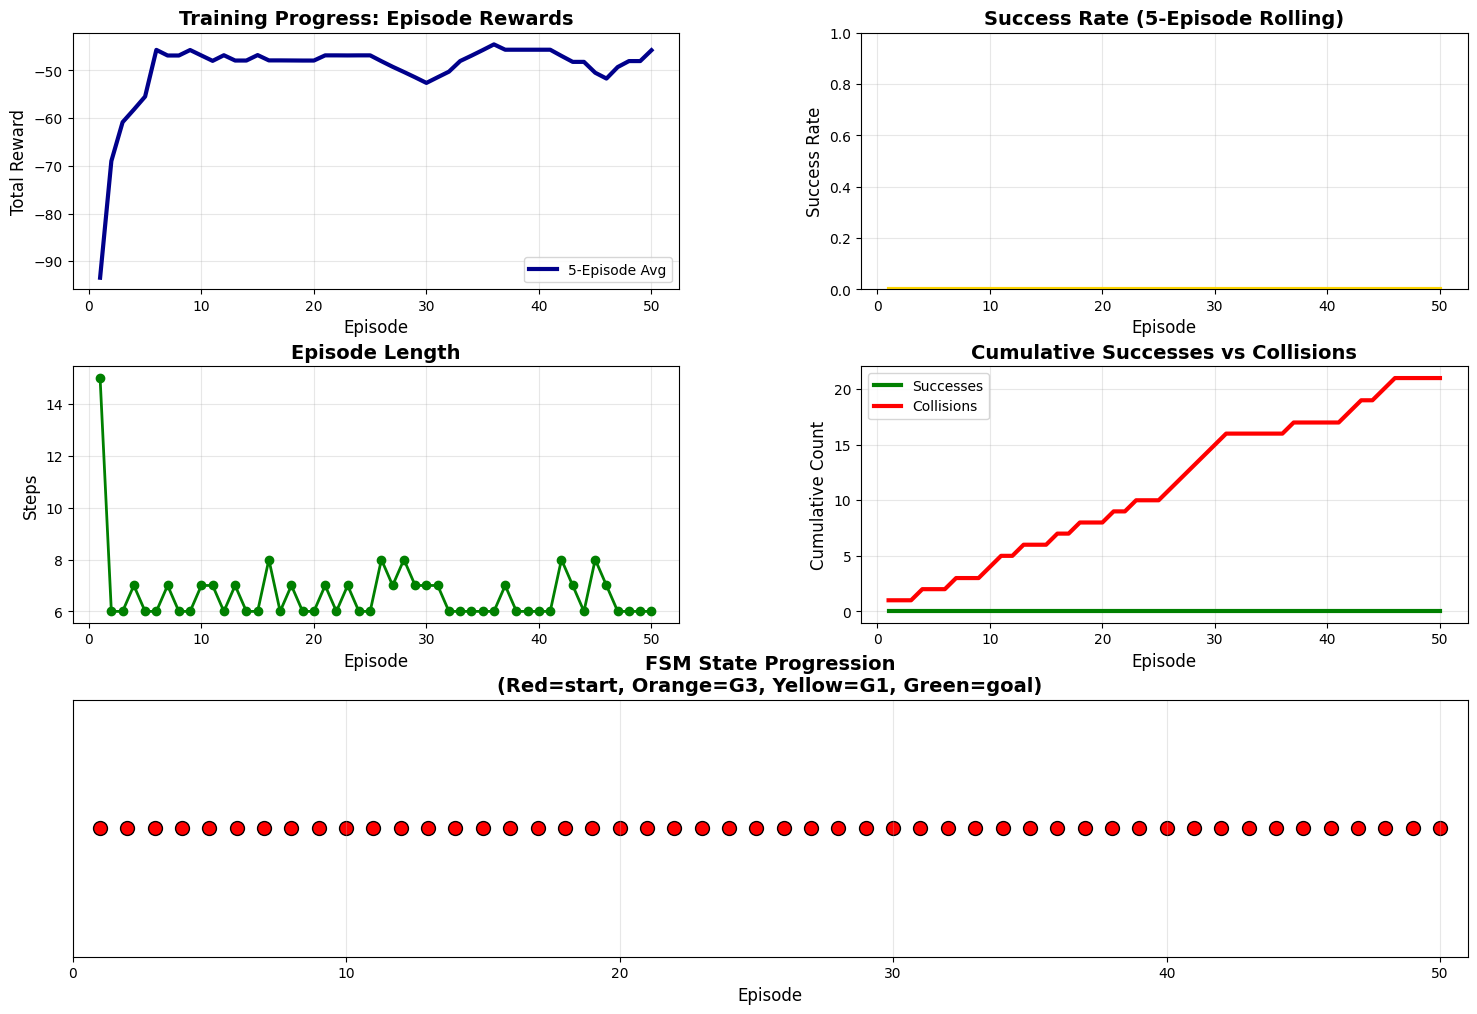


📊 TRAINING SUMMARY

📈 Performance Metrics:
  Total episodes: 50
  Success rate: 0/50 (0.0%)
  Mean reward: -48.42
  Final reward (last 10): -48.13

📊 Learning Progress:
  Early success rate (ep 1-10): 0.0%
  Late success rate (ep 41-50): 0.0%
  Improvement: +0.0%
  ⚠️  No clear improvement yet

🎯 FSM Progression:
  Stuck at start: 50
  Reached G3: 0
  Reached G1: 0
  Reached goal: 0

🔄 Co-Evolution Statistics:
  Safe states collected: 284
  Unsafe states collected: 50
  Goal states collected: 0
  Total training steps: 334

✅ Joint training complete!
   IntegratedTrainer automatically updated CBF/CLF during exploration.


In [ ]:
# ============================================================================
# TEST 7.2: JOINT Training - Using IntegratedTrainer (Algorithm 2)
# ============================================================================

from src.training.training_utils import SubgoalRewardWrapper, compute_training_metrics
from src.utils.visualization import plot_training_progress, print_training_summary

print("\n" + "=" * 70)
print("JOINT TRAINING: CBF, CLF, and Policy Co-Evolution")
print("=" * 70)

print("\n🎯 Using IntegratedTrainer (implements Paper Algorithm 2):")
print(f"   - Dynamics updates: every {DYNAMICS_UPDATE_FREQ} steps")
print(f"   - CBF updates: every {CBF_UPDATE_FREQ} steps")
print(f"   - CLF updates: every {CLF_UPDATE_FREQ} steps")
print(f"   - Policy updates: every step")

print("\n🏋️  Running 50 episodes with joint training...")

# Create environment with reward shaping
env_train_base = WarehouseEnvironment()
fsm_for_wrapper = FSMAutomaton(fsm_states, fsm_transitions, 'start', predicates)
env_train = SubgoalRewardWrapper(env_train_base, fsm_for_wrapper)

# Track metrics
episode_rewards = []
episode_steps = []
episode_success = []
episode_collisions = []
subgoals_reached = []

num_episodes = 50

# Training loop
for episode in range(num_episodes):
    trainer.fsm.current_state_id = 'start'
    
    # Run episode - IntegratedTrainer handles all updates internally!
    stats = trainer.training_episode(env_train, max_steps=100)
    
    episode_rewards.append(stats['reward'])
    episode_steps.append(stats['steps'])
    episode_success.append(stats['goal_reached'])
    episode_collisions.append(stats['reward'] < -50 and not stats['goal_reached'])
    subgoals_reached.append(trainer.fsm.current_state_id)
    
    # Progress updates
    if (episode + 1) % 10 == 0:
        recent_success = sum(episode_success[-10:])
        recent_reward = np.mean(episode_rewards[-10:])
        print(f"\n  Episodes {episode-9:2d}-{episode+1:2d}:")
        print(f"    Successes: {recent_success}/10, Avg reward: {recent_reward:6.1f}")
        print(f"    Data collected: {len(trainer.safe_states)} safe, "
              f"{len(trainer.unsafe_states)} unsafe, {len(trainer.goal_states)} goal")

# Compute metrics
metrics = compute_training_metrics(episode_rewards, episode_success)

# Visualize
fig = plot_training_progress(metrics, episode_steps, subgoals_reached, episode_collisions)
plt.show()

# Print summary
print_training_summary(metrics, subgoals_reached, trainer)

print("\n✅ Joint training complete!")
print("   IntegratedTrainer automatically updated CBF/CLF during exploration.")


Testing RL-Trained Policy

🎯 Rolling out RL-trained policy...
  Start: [0.5 0.2]
  Target: [6.5 0.5]
  Initial distance: 6.01m
    Step 0: pos=(0.51, 0.19), dist=6.00m
    💥 COLLISION at step 5!

  Final: pos=(0.71, -0.01), dist=5.81m
  Steps: 6
  Collision: True
  Success: False

📊 Creating trajectory visualization...


/Users/matthewtaruno/dev/long-horizon/src/visualization.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(
/Users/matthewtaruno/dev/long-horizon/src/visualization.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(


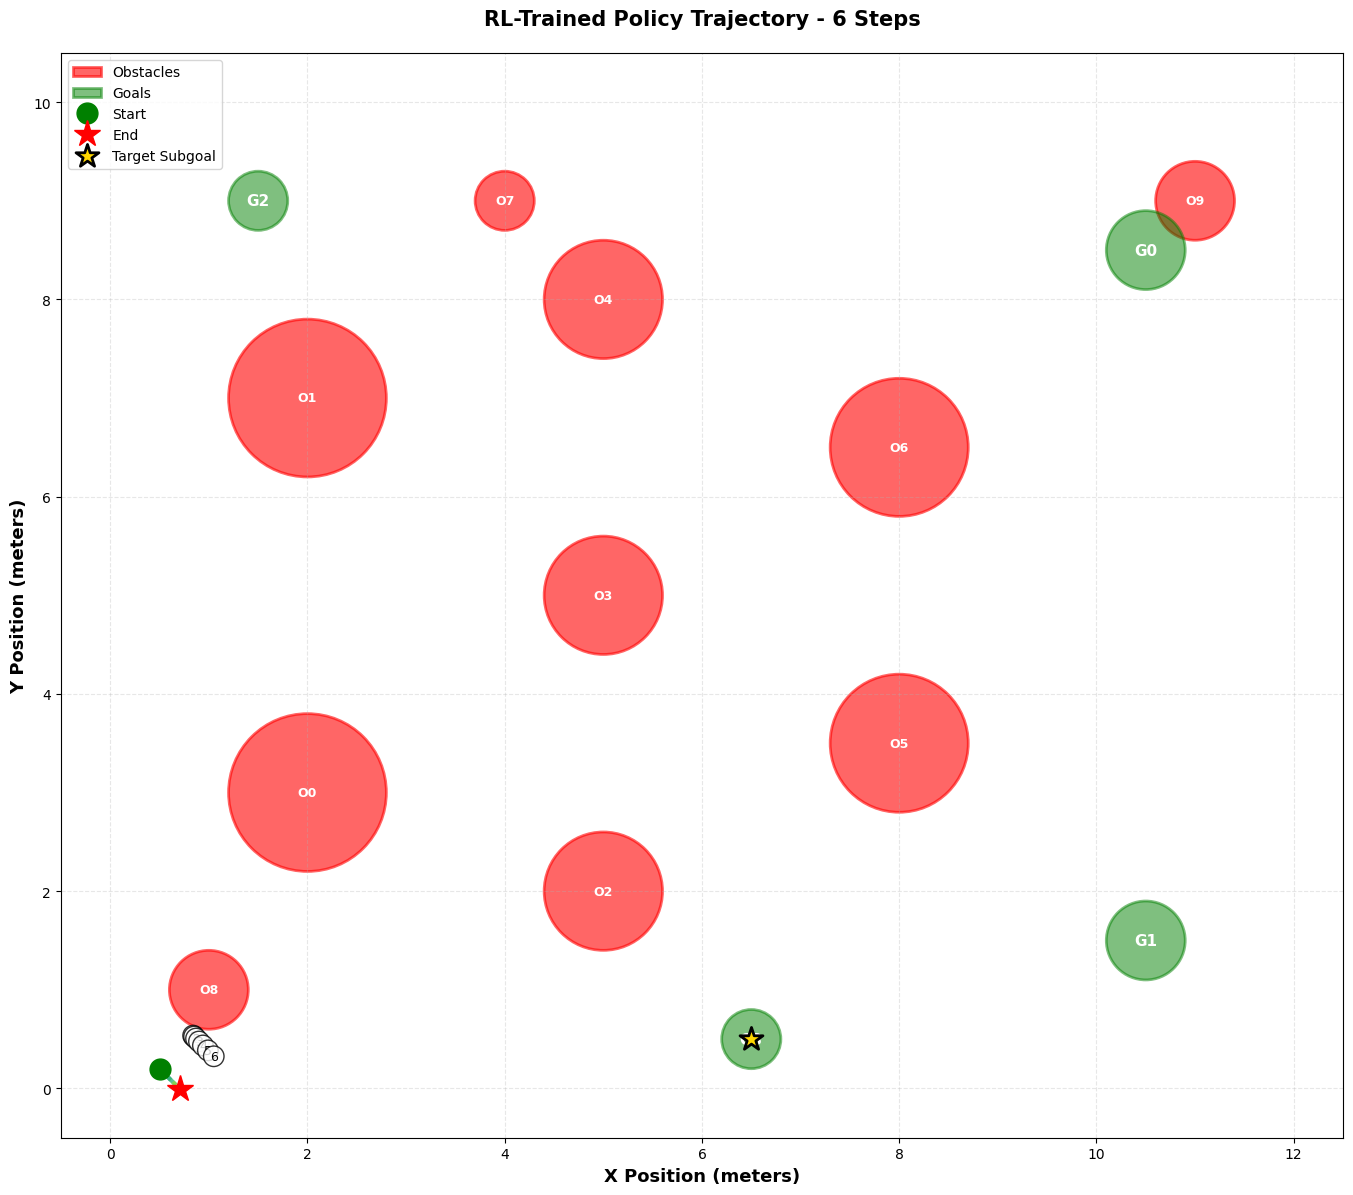


OBSERVATIONS:
• Only 5 training episodes is NOT enough for good performance
• The policy is still learning - needs more episodes (50-100+)
• Early episodes: Random exploration → collisions
• With more training: Policy improves via reward feedback + CBF/CLF
• This demonstrates the RL training loop works!

Next steps for better results:
  1. Train for 50-100+ episodes
  2. Pretrain CBF/CLF on initial dataset (we did this!)
  3. Adjust hyperparameters (learning rate, penalties)
  4. Use curriculum learning (easier goals first)

✅ IntegratedTrainer test complete!


In [15]:
# ============================================================================
# TEST 7.3: Test RL-Trained Policy
# ============================================================================

print("\n" + "=" * 70)
print("Testing RL-Trained Policy")
print("=" * 70)

# Function to rollout trained policy
def rollout_rl_policy(policy, max_steps=100):
    """Rollout the RL-trained policy."""
    env_test = WarehouseEnvironment()
    initial_state = env_test.reset()
    target_subgoal = torch.FloatTensor([[6.5, 0.5, 0.0, 0.0]])
    
    trajectory = [initial_state.copy()]
    current_state_env = initial_state.copy()
    
    print(f"\n🎯 Rolling out RL-trained policy...")
    print(f"  Start: {initial_state[:2]}")
    print(f"  Target: {target_subgoal[0, :2].numpy()}")
    print(f"  Initial distance: {np.linalg.norm(initial_state[:2] - target_subgoal[0, :2].numpy()):.2f}m")
    
    for step in range(max_steps):
        state_tensor = torch.FloatTensor([current_state_env])
        
        with torch.no_grad():
            action = policy(state_tensor, target_subgoal).numpy()[0]
        
        next_state, reward, done, info = env_test.step(action)
        trajectory.append(next_state.copy())
        current_state_env = next_state.copy()
        
        if step % 20 == 0:
            dist = np.linalg.norm(current_state_env[:2] - target_subgoal[0, :2].numpy())
            print(f"    Step {step}: pos=({current_state_env[0]:.2f}, {current_state_env[1]:.2f}), dist={dist:.2f}m")
        
        if info['collision']:
            print(f"    💥 COLLISION at step {step}!")
            break
        if info['success']:
            print(f"    🎉 SUCCESS at step {step}!")
            break
    
    final_state = trajectory[-1]
    final_distance = np.linalg.norm(final_state[:2] - target_subgoal[0, :2].numpy())
    
    print(f"\n  Final: pos=({final_state[0]:.2f}, {final_state[1]:.2f}), dist={final_distance:.2f}m")
    print(f"  Steps: {len(trajectory) - 1}")
    print(f"  Collision: {info['collision']}")
    print(f"  Success: {info['success']}")
    
    return {
        'trajectory': trajectory,
        'steps': len(trajectory) - 1,
        'final_distance': final_distance,
        'collision': info['collision'],
        'success': info['success']
    }, env_test

# Test RL policy
rl_stats, rl_env = rollout_rl_policy(policy_rl, max_steps=100)

# Visualize trajectory
print(f"\n📊 Creating trajectory visualization...")

viz = EnvironmentVisualizer(rl_env)
fig, ax = viz.plot_trajectory_sequence(
    rl_stats['trajectory'],
    title=f"RL-Trained Policy Trajectory - {rl_stats['steps']} Steps"
)

# Add target marker
ax.scatter(6.5, 0.5, c='gold', s=300, marker='*', edgecolor='black', linewidth=2,
           label='Target Subgoal', zorder=10)
ax.legend()

plt.tight_layout()
plt.show()

# Print summary

print("\n" + "=" * 70)
print("OBSERVATIONS:")
print("="*70)
print("• Only 5 training episodes is NOT enough for good performance")
print("• The policy is still learning - needs more episodes (50-100+)")
print("• Early episodes: Random exploration → collisions")
print("• With more training: Policy improves via reward feedback + CBF/CLF")
print("• This demonstrates the RL training loop works!")
print("")
print("Next steps for better results:")
print("  1. Train for 50-100+ episodes")
print("  2. Pretrain CBF/CLF on initial dataset (we did this!)")
print("  3. Adjust hyperparameters (learning rate, penalties)")
print("  4. Use curriculum learning (easier goals first)")
print("="*70)
print("\n✅ IntegratedTrainer test complete!")


DEEP DIAGNOSTICS: Understanding Training Failures

🔍 Diagnostic 1: Policy Action Analysis

Policy actions toward first subgoal G3 (6.5, 0.5):
  State 1 [0.5 0.2]: action=[ 0.99999267 -0.99928916], alignment=0.671
  State 2 [2.  0.5]: action=[ 0.99999297 -0.99933326], alignment=0.707
  State 3 [4.  0.5]: action=[ 0.99996215 -0.99972993], alignment=0.707
  State 4 [6.5 0.5]: action=[-0.99997854 -0.99928373], alignment=0.000
  State 5 [8.  0.8]: action=[-0.99998546 -0.9986241 ], alignment=0.832
  State 6 [10.5  1.5]: action=[-0.99998647 -0.99815494], alignment=0.858

🔍 Diagnostic 2: CBF/CLF Values Along Path

Safety (CBF) and Goal-seeking (CLF) along path:
  Position [0.5 0.2]: h(s)=+0.043 ✓ SAFE, V(s)=0.172
  Position [2.  0.5]: h(s)=-0.183 ✗ UNSAFE, V(s)=0.029
  Position [4.  0.5]: h(s)=-0.023 ✗ UNSAFE, V(s)=0.023
  Position [6.5 0.5]: h(s)=+0.044 ✓ SAFE, V(s)=0.022
  Position [8.  0.8]: h(s)=+0.022 ✓ SAFE, V(s)=0.021
  Position [10.5  1.5]: h(s)=-0.022 ✗ UNSAFE, V(s)=0.021

🔍 Diagnost

/var/folders/1d/6wsgmpys5l54mg7q7hc6flwm0000gn/T/ipykernel_65381/3031084038.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'], color='red', alpha=0.3, edgecolor='darkred', linewidth=2)
/var/folders/1d/6wsgmpys5l54mg7q7hc6flwm0000gn/T/ipykernel_65381/3031084038.py:85: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(goal['center'], goal['radius'], color='green', alpha=0.2, edgecolor='darkgreen', linewidth=2)
/var/folders/1d/6wsgmpys5l54mg7q7hc6flwm0000gn/T/ipykernel_65381/3031084038.py:101: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'], color='none', edgecolor='darkred', linewidth=2)
/var/folders/1d/6wsgmpys5l54mg7q7hc6flwm0000gn/T/ipykernel_65381/3031084038.py:104: UserWarning: Setting the 'color' property w

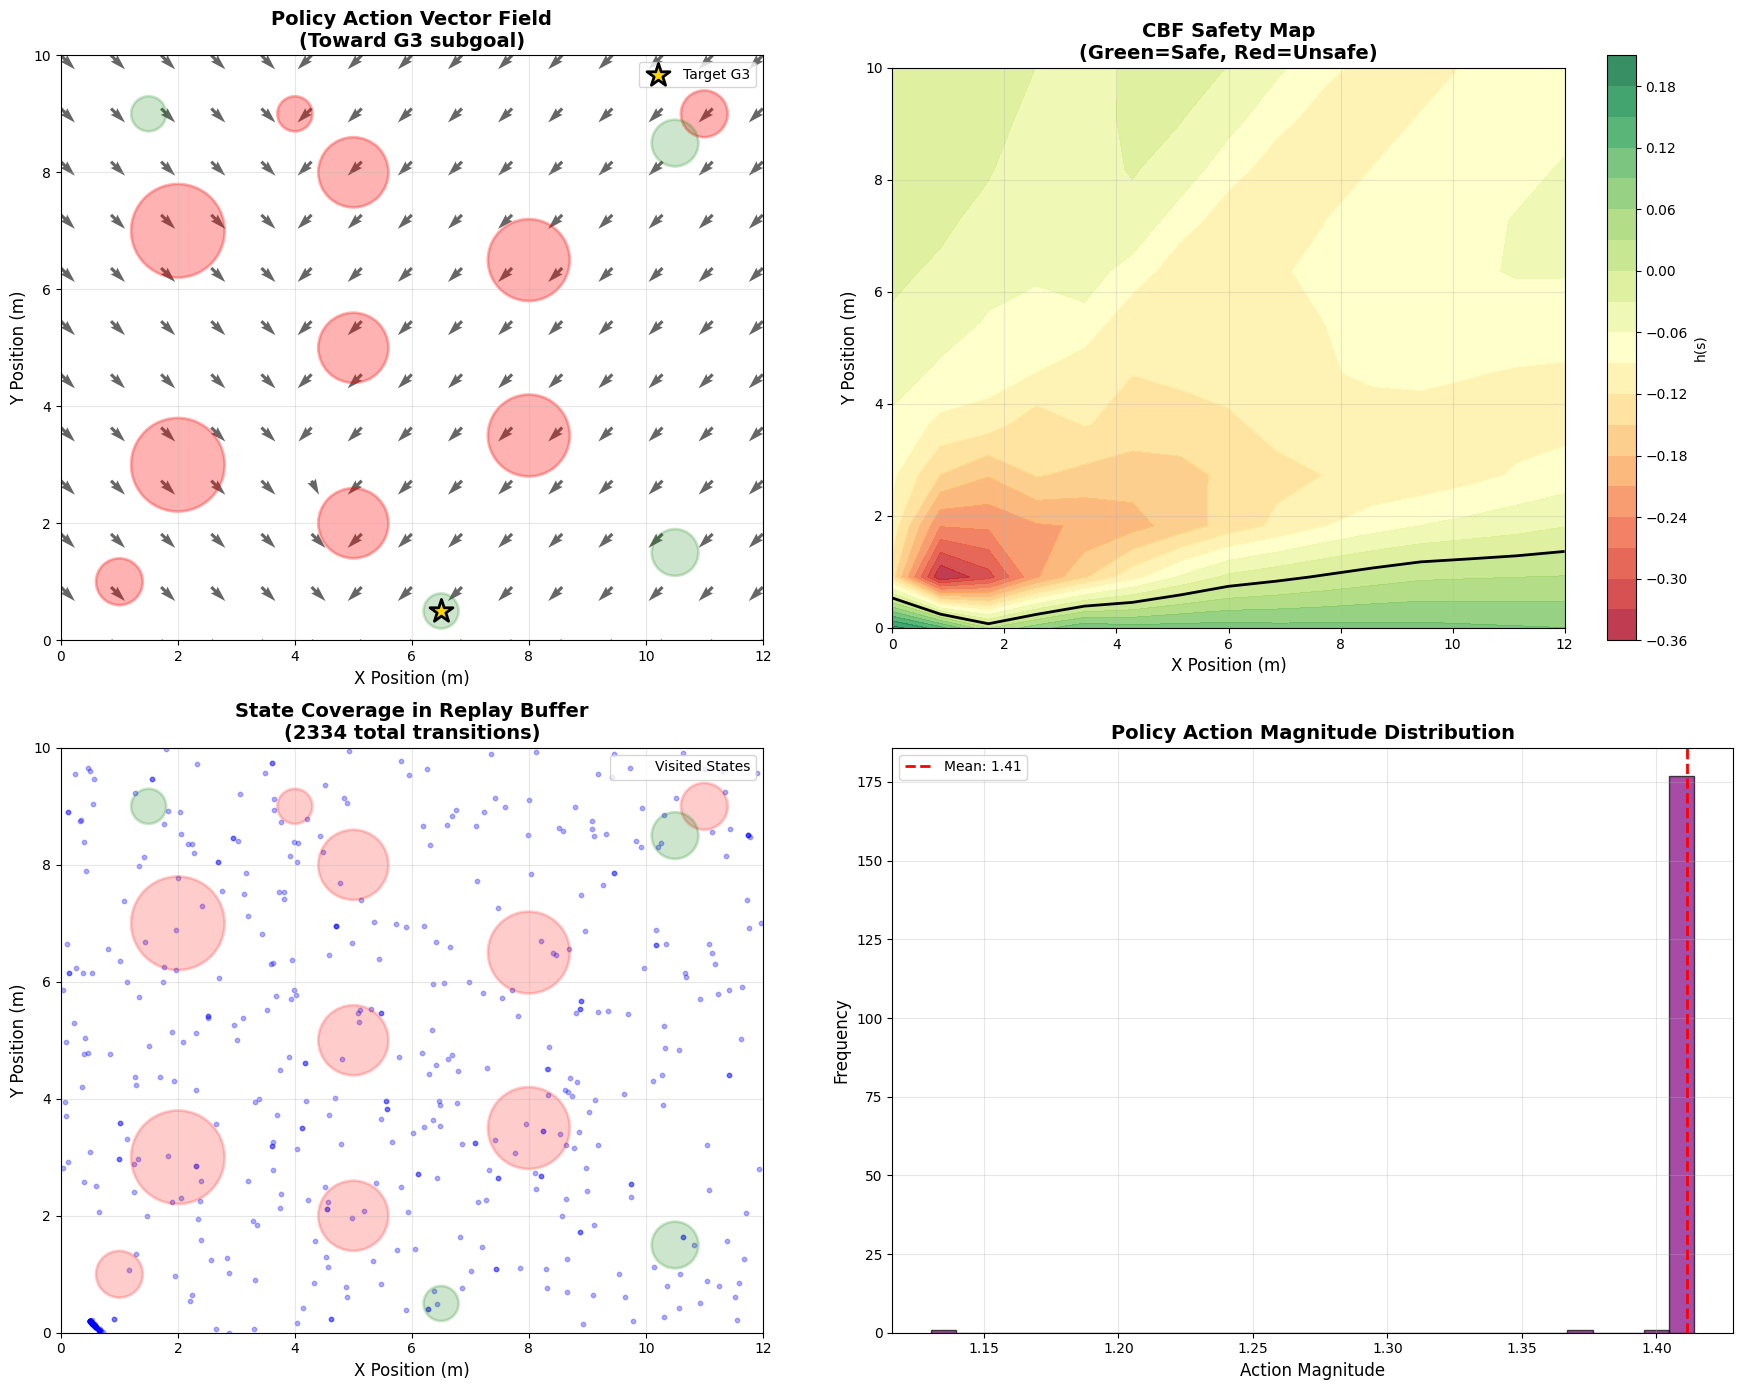


DIAGNOSTIC FINDINGS:
Check the plots above to identify issues:
1. Vector field: Are arrows pointing toward G3?
2. CBF map: Is the safe region (green) correct?
3. State coverage: Is robot exploring diverse states?
4. Action magnitudes: Are actions too weak/strong?


In [16]:
# ============================================================================
# TEST 7.4: Diagnostic Visualizations - Why Is Training Failing?
# ============================================================================

print("\n" + "=" * 70)
print("DEEP DIAGNOSTICS: Understanding Training Failures")
print("=" * 70)

# Diagnostic 1: Check if policy is actually learning anything
print("\n🔍 Diagnostic 1: Policy Action Analysis")

# Sample states along the intended path
test_positions = [
    np.array([0.5, 0.2, 0.0, 0.0]),   # Start
    np.array([2.0, 0.5, 0.0, 0.0]),   # Along bottom
    np.array([4.0, 0.5, 0.0, 0.0]),   # Approaching G3
    np.array([6.5, 0.5, 0.0, 0.0]),   # At G3
    np.array([8.0, 0.8, 0.0, 0.0]),   # Between G3 and G1
    np.array([10.5, 1.5, 0.0, 0.0]),  # At G1
]

subgoal_g3 = torch.FloatTensor([[6.5, 0.5, 0.0, 0.0]])

print(f"\nPolicy actions toward first subgoal G3 (6.5, 0.5):")
for i, state in enumerate(test_positions):
    state_t = torch.FloatTensor([state])
    with torch.no_grad():
        action = policy_rl(state_t, subgoal_g3).numpy()[0]
    
    direction_to_goal = subgoal_g3[0, :2].numpy() - state[:2]
    action_norm = action / (np.linalg.norm(action) + 1e-6)
    dir_norm = direction_to_goal / (np.linalg.norm(direction_to_goal) + 1e-6)
    alignment = np.dot(action_norm, dir_norm)
    
    print(f"  State {i+1} {state[:2]}: action={action}, alignment={alignment:.3f}")

# Diagnostic 2: Check CBF and CLF values along path
print(f"\n🔍 Diagnostic 2: CBF/CLF Values Along Path")

with torch.no_grad():
    states_t = torch.FloatTensor(test_positions)
    h_values = cbf_rl(states_t).squeeze().numpy()
    v_values = clf_rl(states_t).squeeze().numpy()

print(f"\nSafety (CBF) and Goal-seeking (CLF) along path:")
for i, state in enumerate(test_positions):
    h = h_values[i]
    v = v_values[i]
    safe = "✓ SAFE" if h >= 0 else "✗ UNSAFE"
    print(f"  Position {state[:2]}: h(s)={h:+.3f} {safe}, V(s)={v:.3f}")

# Diagnostic 3: Visualize policy behavior in grid
print(f"\n🔍 Diagnostic 3: Policy Vector Field")

# Create grid of states
x_range = np.linspace(0, 12, 15)
y_range = np.linspace(0, 10, 12)
X, Y = np.meshgrid(x_range, y_range)

# Get policy actions at each grid point
actions_x = np.zeros_like(X)
actions_y = np.zeros_like(Y)
cbf_values = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        state = torch.FloatTensor([[X[i,j], Y[i,j], 0.0, 0.0]])
        with torch.no_grad():
            action = policy_rl(state, subgoal_g3).numpy()[0]
            h = cbf_rl(state).item()
        actions_x[i,j] = action[0]
        actions_y[i,j] = action[1]
        cbf_values[i,j] = h

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Policy vector field
ax1.quiver(X, Y, actions_x, actions_y, alpha=0.6, scale=50)
# Draw environment
for obs in env.obstacles:
    circle = patches.Circle(obs['center'], obs['radius'], color='red', alpha=0.3, edgecolor='darkred', linewidth=2)
    ax1.add_patch(circle)
for goal in env.goals:
    circle = patches.Circle(goal['center'], goal['radius'], color='green', alpha=0.2, edgecolor='darkgreen', linewidth=2)
    ax1.add_patch(circle)
ax1.scatter([6.5], [0.5], c='gold', s=300, marker='*', edgecolor='black', linewidth=2, label='Target G3', zorder=10)
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 10)
ax1.set_aspect('equal')
ax1.set_xlabel('X Position (m)', fontsize=12)
ax1.set_ylabel('Y Position (m)', fontsize=12)
ax1.set_title('Policy Action Vector Field\n(Toward G3 subgoal)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: CBF heatmap overlay
im2 = ax2.contourf(X, Y, cbf_values, levels=20, cmap='RdYlGn', alpha=0.8)
ax2.contour(X, Y, cbf_values, levels=[0], colors='black', linewidths=2)
for obs in env.obstacles:
    circle = patches.Circle(obs['center'], obs['radius'], color='none', edgecolor='darkred', linewidth=2)
    ax2.add_patch(circle)
for goal in env.goals:
    circle = patches.Circle(goal['center'], goal['radius'], color='none', edgecolor='darkgreen', linewidth=2)
    ax2.add_patch(circle)
ax2.set_xlim(0, 12)
ax2.set_ylim(0, 10)
ax2.set_aspect('equal')
ax2.set_xlabel('X Position (m)', fontsize=12)
ax2.set_ylabel('Y Position (m)', fontsize=12)
ax2.set_title('CBF Safety Map\n(Green=Safe, Red=Unsafe)', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=ax2, label='h(s)')
ax2.grid(True, alpha=0.3)

# Plot 3: Training dynamics - buffer composition
buffer_states = []
for i in range(min(len(buffer_rl), 500)):
    # Sample from buffer
    batch = buffer_rl.sample(1)
    buffer_states.append(batch['states'].numpy()[0])

if buffer_states:
    buffer_states = np.array(buffer_states)
    ax3.scatter(buffer_states[:, 0], buffer_states[:, 1], c='blue', s=10, alpha=0.3, label='Visited States')
    for obs in env.obstacles:
        circle = patches.Circle(obs['center'], obs['radius'], color='red', alpha=0.2, edgecolor='darkred', linewidth=2)
        ax3.add_patch(circle)
    for goal in env.goals:
        circle = patches.Circle(goal['center'], goal['radius'], color='green', alpha=0.2, edgecolor='darkgreen', linewidth=2)
        ax3.add_patch(circle)
    ax3.set_xlim(0, 12)
    ax3.set_ylim(0, 10)
    ax3.set_aspect('equal')
    ax3.set_xlabel('X Position (m)', fontsize=12)
    ax3.set_ylabel('Y Position (m)', fontsize=12)
    ax3.set_title(f'State Coverage in Replay Buffer\n({len(buffer_rl)} total transitions)', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# Plot 4: Action magnitude distribution
action_mags = np.sqrt(actions_x**2 + actions_y**2).flatten()
ax4.hist(action_mags, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(np.mean(action_mags), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(action_mags):.2f}')
ax4.set_xlabel('Action Magnitude', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Policy Action Magnitude Distribution', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("DIAGNOSTIC FINDINGS:")
print("=" * 70)
print("Check the plots above to identify issues:")
print("1. Vector field: Are arrows pointing toward G3?")
print("2. CBF map: Is the safe region (green) correct?")
print("3. State coverage: Is robot exploring diverse states?")
print("4. Action magnitudes: Are actions too weak/strong?")
print("=" * 70)